# Titanic Survivor Prediction with Logistic Regression

The aim of this project is to creat a classification model using logistic regression to predict whether or not a certain passenger on the titanic survived.

## 1. Import libraries and data

In [290]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [291]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

## 2. Exploratory Data Analysis

Seems fine other than missing values in the Age and column Cabin columns

In [292]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [293]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Which features effect survival rate?

Mean survival rate per class:

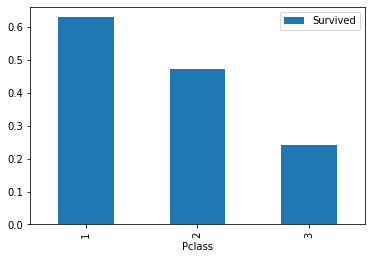

In [294]:
pclass = train.pivot_table(values='Survived', index='Pclass')
pclass.plot.bar()

Mean survival rate per sex:

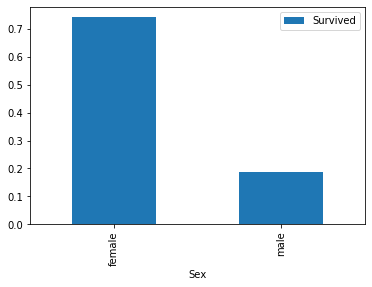

In [295]:
sex = train.pivot_table(values='Survived', index='Sex')
sex.plot.bar()

Distribution of ages for survivors and deaths

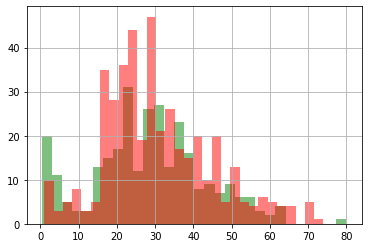

In [296]:
train[train['Survived']==1]['Age'].hist(bins=30, alpha=0.5, color='green')
train[train['Survived']==0]['Age'].hist(bins=30, alpha=0.5, color='red')

Number of siblings: those with more were slightly more likely to survive.

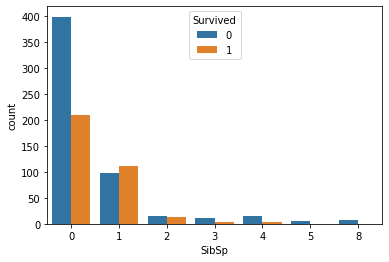

In [297]:
sns.countplot(x='SibSp', data=train, hue='Survived')

Number of parents or children on board: Those with more parents or children were slightly more likely to survive.

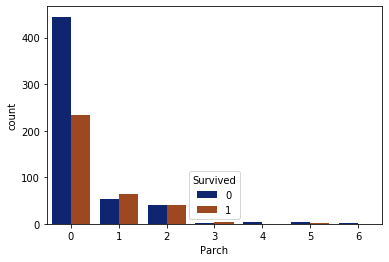

In [298]:
sns.countplot(x='Parch', data=train, hue='Survived', palette='dark')

Price of fare: Those with low fares were less likely to survive.

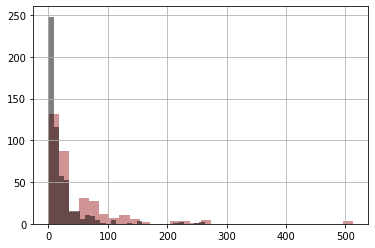

In [299]:
train[train['Survived']==1]['Fare'].hist(bins=30, alpha=0.5, color='brown')
train[train['Survived']==0]['Fare'].hist(bins=30, alpha=0.5, color='black')

Port embarked: Seems to be of some importance too

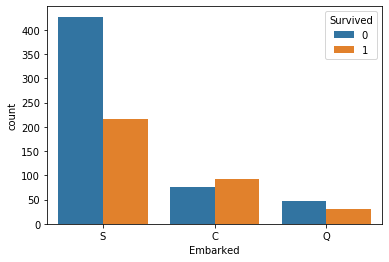

In [300]:
sns.countplot(x='Embarked', data=train, hue='Survived')

## 3. Data cleaning

### Replacing and removing missing values

We mentioned before that there were entries missing from the Age column. It would be better for our model to fill these in rather than just drop them, as by dropping them we are losing a lot of other data. This is called imputation. We want to fill the missing values not with a general mean, but something more informative. Maybe using the mean age for each class is enough.

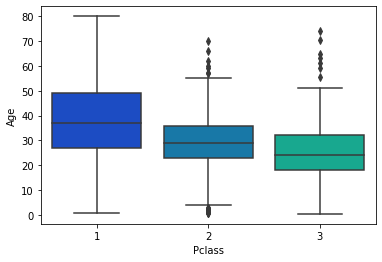

In [301]:
sns.boxplot(x='Pclass', y='Age', data=train, palette='winter')

Ok, so let's replace the missing values/impute with the mean ager per class.

First we define a function for imputation

In [302]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        
        if Pclass == 1:
            return 37
        
        elif Pclass == 2:
            return 29
        
        else:
            return 24
        
    else:
        return Age

In [303]:
train['Age'] = train[['Age','Pclass']].apply(impute_age, axis=1)

Let's remind ourselves what other missing values there are

In [304]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


So let's just drop the cabin column and the missing values from Embarked

In [305]:
train.drop(labels='Cabin',axis=1,inplace=True)

In [306]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [307]:
train.dropna(inplace=True)

### Converting categorical features

Seeing as we will be using logisic regression to predict the survivors, we need to convert the categorical features into an input the logistic regression model will understand. We'll do this using dummy variables.

The columns we need to replace are Sex and Embarked.

In [308]:
sex = pd.get_dummies(train['Sex'],drop_first=True, prefix='Sex')
embark = pd.get_dummies(train['Embarked'], drop_first=True, prefix='Embarked')

In [309]:
train.drop(['Sex', 'Embarked', 'Name', 'Ticket'],axis=1, inplace=True)

In [310]:
train = pd.concat([train, sex, embark], axis=1)

In [311]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


The data is now ready for the model

## 4. Building the Logistic Regression Model

### Splitting the data into test and training data

In order to test the performance of the model after we train it, we need to split the dataset into training and evaluation, or testing sets. In the case of the titanic dataset this is obviously a bit confusing, as there already exist a training and testing dataset. The original testing dataset will be used later. First we want to do our own evaulation, so we will split the original training dataset into train and test.

In [312]:
from sklearn.model_selection import train_test_split

In [313]:
X= train.drop('Survived', axis=1)
y= train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Training the model

In [314]:
from sklearn.linear_model import LogisticRegression

In [315]:
logmodel = LogisticRegression()

In [316]:
logmodel.fit(X_train, y_train)

C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Getting our model to predict values

In [317]:
predictions = logmodel.predict(X_test)

### Evaluating our model

In [318]:
from sklearn.metrics import classification_report

In [319]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       163
           1       0.85      0.65      0.74       104

    accuracy                           0.82       267
   macro avg       0.83      0.79      0.80       267
weighted avg       0.82      0.82      0.81       267



## 5. Using our model to predict values from the original test dataset

### Data cleaning

First we have to make our original test dataframe look like the X_train datafram. Let's see what it looks like

In [320]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [321]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


So we need to fill in some age values and one Fare value (the submission rules require 418 rows). For Age we can do this the same as before in section, 3.

In [322]:
test['Age'] = test[['Age','Pclass']].apply(impute_age, axis=1)

For Fare should we use the same process?

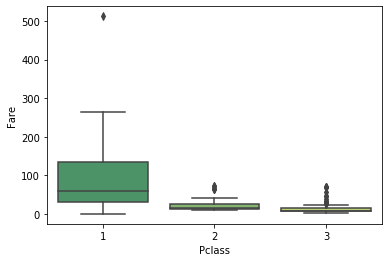

In [323]:
sns.boxplot(x='Pclass', y='Fare', data=test, palette='summer')

It seems so!

In [324]:
test[test['Pclass']==1]['Fare'].mean()

94.28029719626169

In [325]:
test[test['Pclass']==2]['Fare'].mean()

22.20210430107527

In [326]:
test[test['Pclass']==3]['Fare'].mean()

12.459677880184334

In [327]:
def impute_fare(cols):
    Fare = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Fare):
        
        if Pclass == 1:
            return 94
        
        elif Pclass == 2:
            return 22
        
        else:
            return 12
        
    else:
        return Fare

In [328]:
test['Fare'] = test[['Fare','Pclass']].apply(impute_fare, axis=1)

In [329]:
X_train.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
807,808,3,18.0,0,0,7.775,0,0,1
651,652,2,18.0,0,1,23.000,0,0,1
2,3,3,26.0,0,0,7.925,0,0,1
690,691,1,31.0,1,0,57.000,1,0,1
196,197,3,24.0,0,0,7.750,1,1,0


In [330]:
sex_test = pd.get_dummies(test['Sex'],drop_first=True, prefix='Sex')
embark_test = pd.get_dummies(test['Embarked'], drop_first=True, prefix='Embarked')

In [331]:
test.drop(['Sex', 'Embarked', 'Name', 'Ticket'],axis=1, inplace=True)

In [332]:
test = pd.concat([test, sex_test, embark_test], axis=1)

In [333]:
test.drop('Cabin',axis=1, inplace=True)

In [334]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,1,1,0
1,893,3,47.0,1,0,7.0000,0,0,1
2,894,2,62.0,0,0,9.6875,1,1,0
3,895,3,27.0,0,0,8.6625,1,0,1
4,896,3,22.0,1,1,12.2875,0,0,1


In [335]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Sex_male       418 non-null uint8
Embarked_Q     418 non-null uint8
Embarked_S     418 non-null uint8
dtypes: float64(2), int64(4), uint8(3)
memory usage: 20.9 KB


Now we can use our trained model to predict off our test dataset

### Predictions

In [338]:
test_predictions = logmodel.predict(test)

## 6. Saving the predictions to submit to kaggle

Our predictions are in an array and need their corresponding passenger ID

In [341]:
test_predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [351]:
len(test_predictions)

418

In [350]:
test_ids = test['PassengerId']

In [349]:
len(test_ids)

418

In [352]:
submission_dict = {'PassengerId':test_ids, 'Survived':test_predictions}

In [353]:
submission_df = pd.DataFrame(submission_dict)

In [354]:
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


Looks like it's ready to save and submit

In [357]:
submission_df.to_csv('submission.csv',index=False)